In [2]:
# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from OA_utils.data_utils import *

In [3]:
data_dir = "C:\\Users\\bakel\\Downloads\\"

# load the data
grf_data = np.load(data_dir + 'OA_grf.npy', mmap_mode='r')
muscle_data = np.load(data_dir + 'OA_muscle.npy', mmap_mode='r')

grf_labels = ['GRF_x', 'GRF_y', 'GRF_z']
muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']

grf_dict = {0: 'GRF_x', 1: 'GRF_y', 2: 'GRF_z'}
muscle_dict = {0: 'tibpost', 1: 'tibant', 2: 'edl', 3: 'ehl', 4: 'fdl', 5: 'fhl', 6: 'perbrev', 7: 'perlong', 8: 'achilles'}

In [4]:
data = np.concatenate((grf_data, muscle_data), axis=2)
# print(data.shape)

np.random.seed(42)
np.random.shuffle(data)

In [5]:
num_samples = data.shape[0]
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)

print(f"Number of samples: {num_samples}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")

Number of samples: 843
Train size: 674
Validation size: 84


In [6]:
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (674, 100, 12)
Validation data shape: (84, 100, 12)
Test data shape: (85, 100, 12)


In [7]:
X_train, y_train = train_data[:, :, :3], train_data[:, :, 3:]
X_val, y_val = val_data[:, :, :3], val_data[:, :, 3:]
X_test, y_test = test_data[:, :, :3], test_data[:, :, 3:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (674, 100, 3)
y_train shape: (674, 100, 9)
X_val shape: (84, 100, 3)
y_val shape: (84, 100, 9)
X_test shape: (85, 100, 3)
y_test shape: (85, 100, 9)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]),
 [Text(0, -1000.0, '−1000'),
  Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000'),
  Text(0, 6000.0, '6000'),
  Text(0, 7000.0, '7000')])

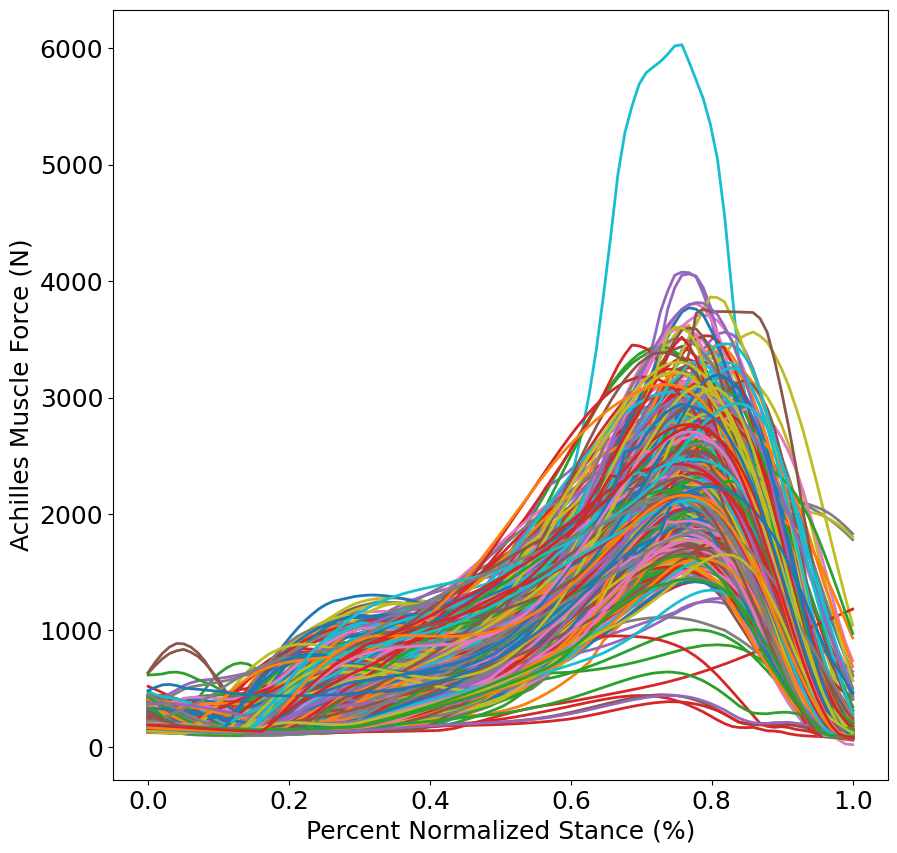

In [8]:
figure = plt.figure(figsize=(10, 10))

num_achilles_segments = len(y_train[:, :, 8])
perc_stance = np.linspace(0, 1, 100)

for i in range(num_achilles_segments):
    plt.plot(perc_stance, y_train[i, :, 8], linewidth=2)

plt.ylabel("Achilles Muscle Force (N)", fontsize=18)
plt.xlabel("Percent Normalized Stance (%)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads, output_size, lstm_dropout=0.0, attn_dropout=0.0):
        super(LSTMAttentionModel, self).__init__()
        
        # define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=lstm_dropout)
        
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, dropout=attn_dropout)
        
        # fully connected layer to map from hidden state to output features
        self.fc = nn.Linear(hidden_size, output_size)
        
        # self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # pass through LSTM layer
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch, seq_length, hidden_size)
        lstm_out = lstm_out.permute(1, 0, 2)  # lstm_out shape: (seq_length, batch, hidden_size)
        # print(lstm_out.shape)
        
        # Self-attention forward pass
        attention_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        attention_out = attention_out.permute(1, 0, 2) # attention_out shape: (batch, seq_length, hidden_size)
        # print(attention_out.shape)
        
        # # Aggregate attention output (mean pooling across sequence length)
        # context = torch.mean(attention_out, dim=0)  # context: (batch_size, hidden_dim)
        # print(context.shape)
        
        # pass through fully connected layer to get the output
        output = self.fc(attention_out) # output shape: (batch, seq_length, output_size)
        # print(output.shape)
        
        return output

In [10]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [11]:
# model parameters
input_size = 3           # grf features (x, y, z)
hidden_size = 64         # hidden size for LSTM (tunable)
num_layers = 2           # number of LSTM layers
num_heads = 4            # number of heads for multi-head attention
output_size = 9          # muscle force features
dropout = 0.1            # dropout rate

In [12]:
# create the model
model = LSTMAttentionModel(input_size, hidden_size, num_layers, num_heads, output_size, dropout)
model.to(device)

LSTMAttentionModel(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=9, bias=True)
)

In [13]:
from torch.utils.data import TensorDataset, DataLoader

# hyperparameters
num_epochs = 1000
learning_rate = 1e-3
batch_size = 32

# loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# create dataloaders from datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# early stopping setup
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

# training loop
for epoch in range(num_epochs):
    # set model to training mode
    model.train()
    
    # initialize training loss
    train_loss = 0
    
    # iterate over the training data
    for X_batch, y_batch in train_loader:
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # update training loss
        train_loss += loss.item() * X_batch.size(0)
    
    # average training loss over number of samples
    train_loss /= len(train_loader.dataset)
    
    # set model to evaluation mode
    model.eval()
    
    # initialize validation loss
    val_loss = 0
    
    # no need to calculate gradients during validation
    with torch.no_grad():
        # iterate over the validation data
        for X_batch, y_batch in val_loader:
            # forward pass
            outputs = model(X_batch)
            
            # calculate loss
            loss = criterion(outputs, y_batch)
            
            # update validation loss
            val_loss += loss.item() * X_batch.size(0)
    
    # average validation loss over number of samples
    val_loss /= len(val_loader.dataset)
    
    # print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
    # early stopping check
    if val_loss < best_val_loss:
        # save best validation loss
        best_val_loss = val_loss
        
        # reset epochs without improvement
        epochs_without_improvement = 0
    else:
        # increment epochs without improvement
        epochs_without_improvement += 1

    # break if patience limit is reached
    if epochs_without_improvement >= patience:
        break

Epoch [10/1000], Train Loss: 64092.5377, Val Loss: 47244.0625
Epoch [20/1000], Train Loss: 14063.0136, Val Loss: 10592.8172
Epoch [30/1000], Train Loss: 15047.4383, Val Loss: 10180.5420
Epoch [40/1000], Train Loss: 9995.1929, Val Loss: 8329.0015
Epoch [50/1000], Train Loss: 8488.4563, Val Loss: 6995.0388


In [15]:
# convert test data to torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# set model to evaluation mode
model.eval()

# initialize test loss
test_loss = 0

# no need to calculate gradients during testing
with torch.no_grad():
    # forward pass
    test_outputs = model(X_test_tensor)
    
    # calculate loss
    test_loss = criterion(test_outputs, y_test_tensor).item()

# print test loss
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 10336.9727


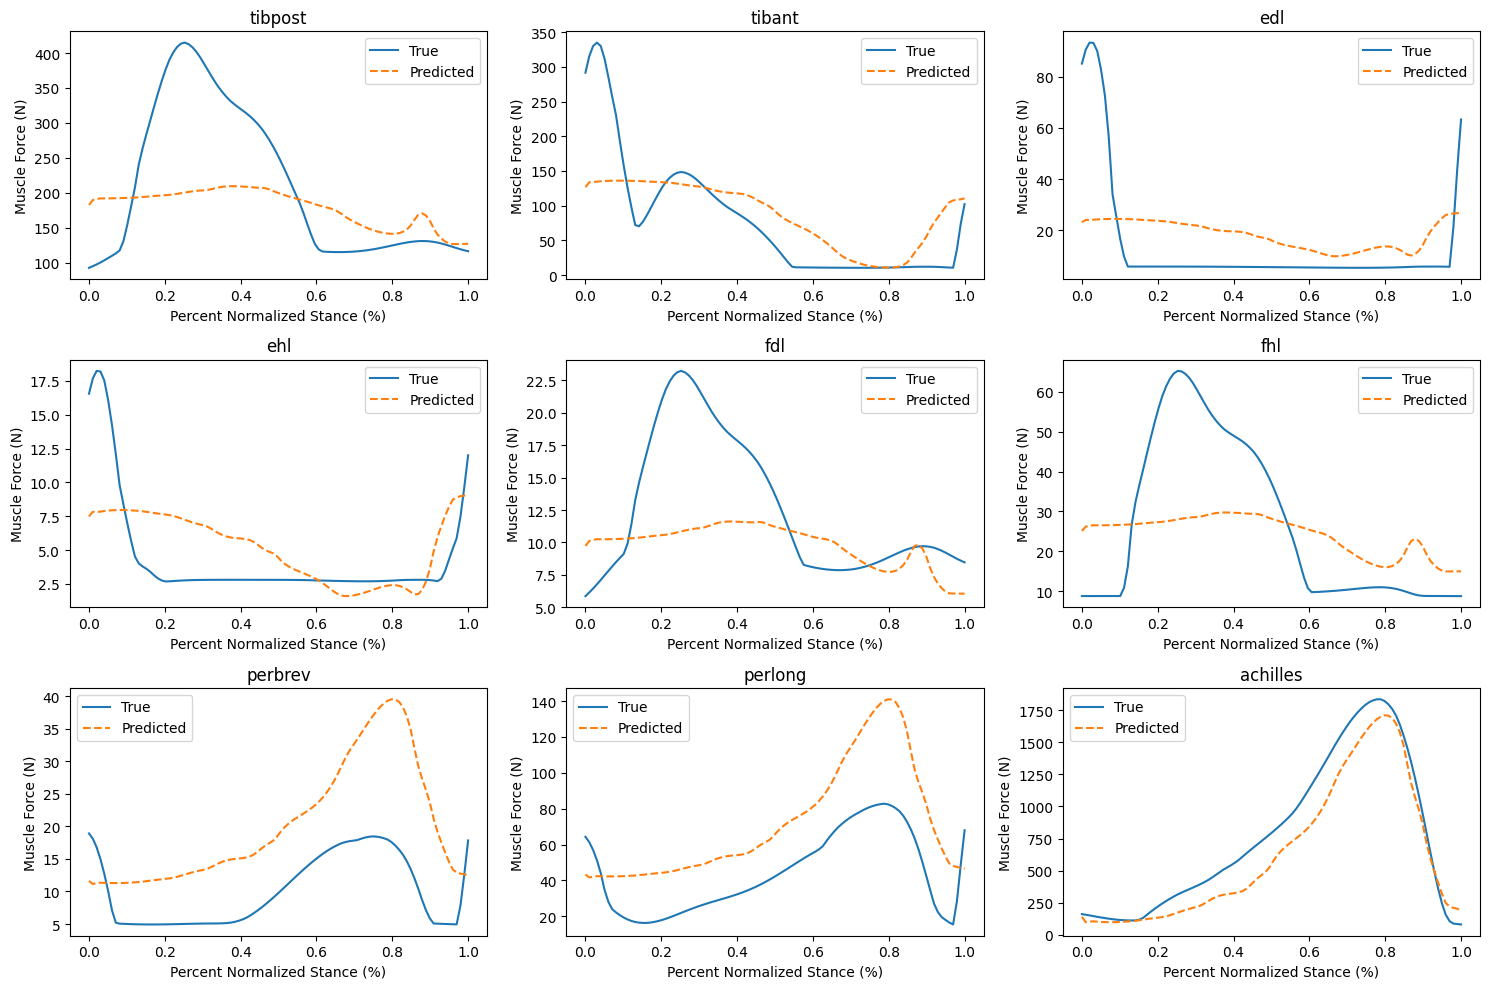

In [16]:
# Move predictions and ground truth to CPU for visualization
pred = test_outputs[0].cpu().numpy()  # Shape: (seq_length, 9)
true = y_test_tensor[0].cpu().numpy()      # Shape: (seq_length, 9)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i in range(9):
    axes[i].plot(perc_stance, true[:, i], label="True")
    axes[i].plot(perc_stance, pred[:, i], label="Predicted", linestyle='dashed')
    axes[i].set_title(muscle_dict[i])
    axes[i].set_xlabel("Percent Normalized Stance (%)")
    axes[i].set_ylabel("Muscle Force (N)")
    axes[i].legend()

plt.tight_layout()
plt.show()